<a href="https://colab.research.google.com/github/one-2730/ESAA-24-2/blob/Assignment/ESSA_YB_1007_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#앙상블 학습

투표로 최종 결과를 채택하는 앙상블 알고리즘
1. Voting
서로 다른 알고리즘을 가진 분류기가 같은 데이터셋을 학습해 예측한 결과로 투표
2. Bagging
데이터셋을 여러 subset으로 나눠 같은 알고리즘을 가진 분류기가 각각 학습해 예측한 결과로 투표

투표 유형
1. Hard Voting
예측한 결과값들 중 다수의 분류기가 결정한 예측값을 최종 보팅 결과로 선택
2. Soft Voting *
분류기들의 레이블 값 결정 확률을 모두 더하고 이를 평균내어 가장 확률이 높은 레이블 값을 최종 보팅 결과로 채택

##VotingClassifier

In [1]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns = cancer.feature_names)
data_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [2]:
lr_clf = LogisticRegression(solver = 'liblinear')
knn_clf = KNeighborsClassifier(n_neighbors = 8)

vo_clf = VotingClassifier(estimators = [('LR', lr_clf), ('KNN', knn_clf)], voting = 'soft')

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size = 0.2, random_state = 156)

vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
  classifier.fit(X_train, y_train)
  pred = classifier.predict(X_test)
  class_name = classifier.__class__.__name__
  print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test, pred)))

Voting 분류기 정확도: 0.9561
LogisticRegression 정확도: 0.9474
KNeighborsClassifier 정확도: 0.9386


#Random Forest

이름이 귀여움...   
트리가 많아서 포레스트라는 발상이 너무 1차원적이고 좋음

**Hyper Parameters**
- n_estimators
- max_features
- max_depth
- min_samples_leaf
- min_samples_split

In [3]:
#데이터 준비

feature_name_df = pd.read_csv('features.txt', sep = '\s+', header = None, names = ['column_index', 'column_name'])
feature_name = feature_name_df.iloc[:, 1].values.tolist()
feature_dup_df = feature_name_df.groupby('column_name').count()

def get_new_feature_name_df(old_feature_name_df):
  feature_dup_df = pd.DataFrame(data = old_feature_name_df.groupby('column_name').cumcount(), columns = ['dup_cnt'])
  feature_dup_df = feature_dup_df.reset_index()
  new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how = 'outer')
  new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x: x[0]+'_'+str(x[1]) if x[1]>0 else x[0], axis = 1)
  new_feature_name_df = new_feature_name_df.drop(['index'], axis = 1)
  return new_feature_name_df

def get_human_dataset():
  feature_name_df = pd.read_csv('features.txt', sep = '\s+', header = None, names = ['colmn_index', 'column_name'])
  new_feature_name_df = get_new_feature_name_df(feature_name_df)
  feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

  X_train = pd.read_csv('X_train.txt', sep = '\s+', names = feature_name)
  X_test = pd.read_csv('X_test.txt', sep = '\s+', names = feature_name)
  y_train = pd.read_csv('y_train.txt', sep = '\s+', header = None, names = ['action'])
  y_test = pd.read_csv('y_test.txt', sep = '\s+', header = None, names = ['action'])

  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

rf_clf = RandomForestClassifier(random_state = 0, max_depth = 8)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤포레스트 정확도: 0.9196


In [5]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [8, 16, 24],
    'min_samples_leaf': [1, 6, 12],
    'min_samples_split': [2, 8, 16]
}

rf_clf = RandomForestClassifier(n_estimators = 100, random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 2, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 2}
최고 예측 정확도: 0.9165


In [6]:
rf_clf1 = RandomForestClassifier(n_estimators = 100, min_samples_leaf = 6, max_depth = 16, min_samples_split = 12, random_state = 0)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

예측 정확도: 0.9260


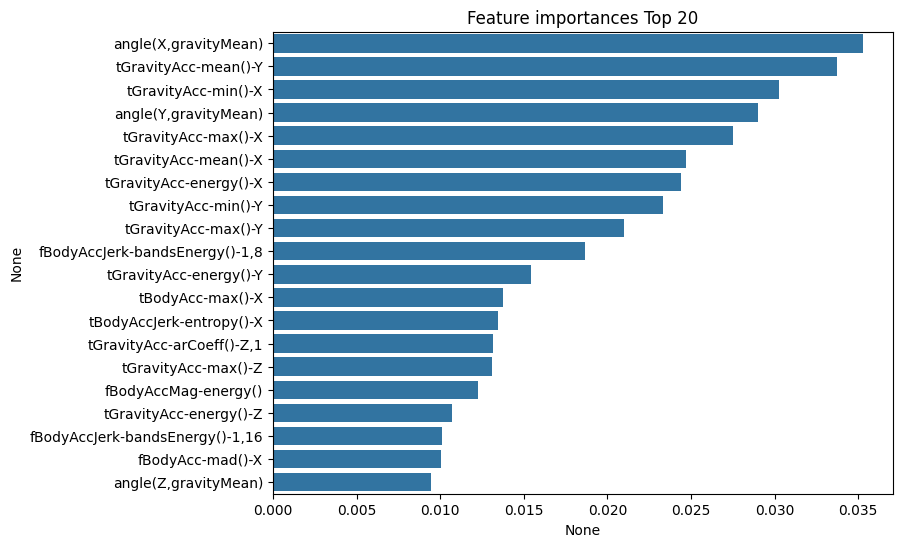

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending = False)[:20]

plt.figure(figsize = (8, 6))
plt.title('Feature importances Top 20')
sns.barplot(x = ftr_top20, y = ftr_top20.index)
plt.show()

#GBM

**Hyper Parameters**
- 트리모델의 파라미터들
- loss
- learning_rate
- subsample

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state = 0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print('GBM 수행 시간: {0:.1f}초'.format(time.time() - start_time))

GBM 정확도: 0.9386
GBM 수행 시간: 1230.7초


XGBoost

In [9]:
#사이킷런 래퍼 XGBoost 모듈 설치
#!pip install xgboost==1.5.0

In [10]:
#pip install pandas==1.3.5

In [11]:
import xgboost as xgb
from xgboost import XGBClassifier

print(xgb.__version__)
print(pd.__version__)

1.5.0
1.3.5


In [12]:
from xgboost import plot_importance
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
features = dataset.data
labels = dataset.target

cancer_df = pd.DataFrame(data = features, columns = dataset.feature_names)
cancer_df['target'] = labels
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [13]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [14]:
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size = 0.2, random_state = 156)

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 156)

print(X_train.shape, X_test.shape)
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


In [15]:
dtr = xgb.DMatrix(data = X_tr, label = y_tr)
dval = xgb.DMatrix(data = X_val, label = y_val)
dtest = xgb.DMatrix(data = X_test, label = y_test)

params = {
    'max_depth': 3,
    'eta': 0.05,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}
num_rounds = 400

eval_list = [(dtr, 'train'), (dval, 'eval')]

xgb_model = xgb.train(params = params, dtrain = dtr, num_boost_round = num_rounds, early_stopping_rounds = 50, evals = eval_list)

[0]	train-logloss:0.65016	eval-logloss:0.66183
[1]	train-logloss:0.61131	eval-logloss:0.63609
[2]	train-logloss:0.57563	eval-logloss:0.61144
[3]	train-logloss:0.54310	eval-logloss:0.59204
[4]	train-logloss:0.51323	eval-logloss:0.57329
[5]	train-logloss:0.48447	eval-logloss:0.55037
[6]	train-logloss:0.45796	eval-logloss:0.52929
[7]	train-logloss:0.43436	eval-logloss:0.51534
[8]	train-logloss:0.41150	eval-logloss:0.49718
[9]	train-logloss:0.39027	eval-logloss:0.48154
[10]	train-logloss:0.37128	eval-logloss:0.46990
[11]	train-logloss:0.35254	eval-logloss:0.45474
[12]	train-logloss:0.33528	eval-logloss:0.44229
[13]	train-logloss:0.31893	eval-logloss:0.42961
[14]	train-logloss:0.30439	eval-logloss:0.42065
[15]	train-logloss:0.29000	eval-logloss:0.40958
[16]	train-logloss:0.27651	eval-logloss:0.39887
[17]	train-logloss:0.26389	eval-logloss:0.39050
[18]	train-logloss:0.25210	eval-logloss:0.38254
[19]	train-logloss:0.24123	eval-logloss:0.37393
[20]	train-logloss:0.23076	eval-logloss:0.36789
[2

In [16]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10], 3))

preds = [1 if x>0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', pred[:10])

predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.845 0.008 0.68  0.081 0.975 0.999 0.998 0.998 0.996 0.001]
예측값 10개만 표시: [5 5 5 5 5 5 5 5 5 5]


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def get_clf_eval(y_test, pred = None, pred_proba = None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  roc_auc = roc_auc_score(y_test, pred)
  print('오차행렬')
  print(confusion)
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1{3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

get_clf_eval(y_test, preds, pred_probs)

오차행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740, F10.9677, AUC: 0.9465


In [18]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.05, max_depth = 3, eval_metric = 'logloss')
xgb_wrapper.fit(X_train, y_train, verbose = True)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, w_preds, w_pred_proba)

오차행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870, F10.9744, AUC: 0.9530


In [19]:
xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.5, max_depth = 3)
evals = [(X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, eval_set=evals, eval_metric='logloss', verbose=True, early_stopping_rounds=50)

ws50_preds = xgb_wrapper.predict(X_test)
ws50_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.45915
[1]	validation_0-logloss:0.35750
[2]	validation_0-logloss:0.30244
[3]	validation_0-logloss:0.27501
[4]	validation_0-logloss:0.26152
[5]	validation_0-logloss:0.26290
[6]	validation_0-logloss:0.27088
[7]	validation_0-logloss:0.27125
[8]	validation_0-logloss:0.29146
[9]	validation_0-logloss:0.29061
[10]	validation_0-logloss:0.29161
[11]	validation_0-logloss:0.29964
[12]	validation_0-logloss:0.27732
[13]	validation_0-logloss:0.27806
[14]	validation_0-logloss:0.27727
[15]	validation_0-logloss:0.26936
[16]	validation_0-logloss:0.26380
[17]	validation_0-logloss:0.26799
[18]	validation_0-logloss:0.26521
[19]	validation_0-logloss:0.26545
[20]	validation_0-logloss:0.25249
[21]	validation_0-logloss:0.25584
[22]	validation_0-logloss:0.25452
[23]	validation_0-logloss:0.25325
[24]	validation_0-logloss:0.25440
[25]	validation_0-logloss:0.25205
[26]	validation_0-logloss:0.25671
[27]	validation_0-logloss:0.25008
[28]	validation_0-logloss:0.24963
[29]	validation_0-loglos

In [20]:
get_clf_eval(y_test, ws50_preds, ws50_pred_proba)

오차행렬
[[34  3]
 [ 3 74]]
정확도: 0.9474, 정밀도: 0.9610, 재현율: 0.9610, F10.9610, AUC: 0.9400


In [21]:
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds = 10, eval_metric = 'logloss', eval_set = evals, verbose = True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.45915
[1]	validation_0-logloss:0.35750
[2]	validation_0-logloss:0.30244
[3]	validation_0-logloss:0.27501
[4]	validation_0-logloss:0.26152
[5]	validation_0-logloss:0.26290
[6]	validation_0-logloss:0.27088
[7]	validation_0-logloss:0.27125
[8]	validation_0-logloss:0.29146
[9]	validation_0-logloss:0.29061
[10]	validation_0-logloss:0.29161
[11]	validation_0-logloss:0.29964
[12]	validation_0-logloss:0.27732
[13]	validation_0-logloss:0.27806
오차행렬
[[34  3]
 [ 4 73]]
정확도: 0.9386, 정밀도: 0.9605, 재현율: 0.9481, F10.9542, AUC: 0.9335
